## CCD Image Reduction with Python

This week you will apply your Python skills to calibrating actual imaging data from McDonald Observatory so that it is fit for scientific analysis. You will use the data that you reduce this week in the next two labs.

To help you along, we have developed this notebook as a starting point for your analysis.  We will demonstrate how to interact with FITS files and some of the new tricks you will need to use, then we will guide you through the remaining steps to finish the process.

There are three data subdirectories contained in this folder: "dark," "flat," and "ktwo220274129." The first two contain different types of calibration image, while the last folder contains science observations of a pulsating white dwarf star named ktwo220274129.

Note that there will be some free-response questions that you need to answer throughout this Lab.  Please answer the questions on the course Canvas site under "Quizzes/Lab 3 Questions." You will upload your final lab files as responses to this quiz too. The questions are highlighted in this notebook like this:

<mark>Q0: this is what a question that you should answer on Canvas looks like.</mark>

We start by importing all the tools we will need for the lab.

In [1]:
# for handling arrays; image data are arrays!
import numpy as np 
# for plotting and displaying data
import matplotlib.pyplot as plt 
# for making lists of filenames
from glob import glob 
# for reading and writing FITS format data
from astropy.io import fits 
# for calculating the "mode" of arrays
from scipy.stats import mode as spmode
# display figures in this notebook
%matplotlib inline

### Making a Master Dark Frame

The subdirectory "dark/" contains fits files corresponding to two image sequences, each with a different exposure time.

In [2]:
# This indexing displays only every 61st frame
# since I know there are 61 of each
print(glob('dark/*.fits')[::61]) 

['dark/dark_10s-55.fits', 'dark/dark_3s-28.fits']


Some darks were taken with 10-second exposures and some were taken with 3-second exposures. We need to combine these separately into two master darks: one that characterizes the 10-second dark current (+ bias + readnoise), and one the captures the 3-second dark current.

As an example, we provide the code to produce the 10-second dark, but you *must* execute the cells of this notebook yourself to generate the master 10s dark file that you will need later on.

In [3]:
# Start by getting a list of the 10-second darks
filenames = glob('dark/dark_10s-*.fits')
print(len(filenames)) # there are 61 files
print(filenames[:3]) # see what the first three filenames look like

61
['dark/dark_10s-55.fits', 'dark/dark_10s-02.fits', 'dark/dark_10s-14.fits']


In [4]:
# Let's inspect one file to get a sense of the format

# The easiest way to access the header and image data of a 
# FITS file is to use the fits.getheader() and fits.getdata() 
# functions, but you've also seen in the astropy tutorials 
# how to use the more powerful fits.open().

# If you are ever unsure about what arguments a function 
# takes or exactly what it does, you can view the documentation 
# by typing:

? fits.getdata

first = fits.open(filenames[0])
first.info()

# Although the shift+tab trick you already learned shows the 
# same info.

Filename: dark/dark_10s-55.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   (256, 256)   int16 (rescales to uint16)   
Signature:
 fits.getdata(
    filename,
    *args,
    header=None,
    lower=None,
    upper=None,
    view=None,
    **kwargs,
)
Docstring:
Get the data from an extension of a FITS file (and optionally the
header).

Parameters
----------
filename : path-like or file-like
    File to get data from.  If opened, mode must be one of the
    following rb, rb+, or ab+.

ext
    The rest of the arguments are for extension specification.
    They are flexible and are best illustrated by examples.

    No extra arguments implies the primary header::

        getdata('in.fits')

    .. note::
        Exclusive to ``getdata``: if extension is not specified
        and primary header contains no data, ``getdata`` attempts
        to retrieve data from first extension.

    By extension number::

        getdata('in.fits

<mark>Q1: If you wanted fits.getdata() to return the FITS header along with the image data instead of having to call fits.getheader() separately, what argument would you add to the function call? [Submit this as the answer to Question 1 on Canvas]</mark>

In [5]:
# First let's look at the header for the first 10-second dark

header = fits.getheader(filenames[0])

header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXPTIME =                   10 / exposure time                                  
DATE-OBS= '2016-10-31T22:04:00' / date of the observation                       
OBJECT  = 'Dark    '           / name of observed object                        
RA_OBJ  = '' / R.A. of the observation                                          
DEC_OBJ = '' / declination of the observed object                               
OBSERVER= 'ZPV     '           / observer who acquired the data                 
TELESCOP= 'McDonald 2.1m'      / name of telescope                              
INSTRUME= 'ProEM   '        

The headers contains a lot of important "metadata" about the image. We see for example that the shutter was "closed" when this image was taken, as it should be for a dark frame!

<class 'numpy.ndarray'>
(256, 256)


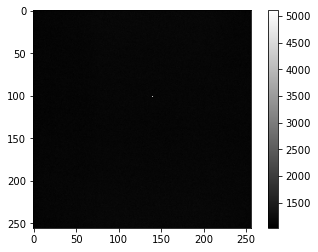

In [6]:
# Now let's see what the data look like.

data = fits.getdata(filenames[0])

# Learn some basic things about how the data were read in.
print(type(data)) # it's a numpy array!
print(data.shape) # the image is 256 x 256 pixels!

# Display the image.
plt.imshow(data,cmap='gray')
plt.colorbar()
plt.show()

Here we've found one of the real weaknesses of Python: it doesn't display astronomical images very well.

In this case, a really high count on one pixel caused the colormap to paint that pixel white and all the others black.  We'd really prefer to see more detail in the image, so we've defined a new function that does a little bit better for you to use in this lab.

However, if you really want to explore the details in the FITS images, you can open the files in a program called "ds9" by typing "ds9 filename.fits" in a Terminal window, which allows you to modify the way the image is displayed interactively.

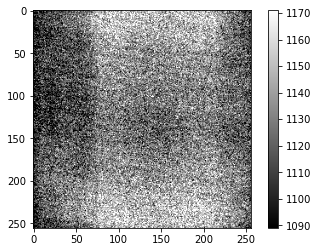

In [7]:
# Define new image display function
def display(data): 
    plt.imshow(data,cmap='gray',vmin=np.percentile(data,5),vmax=np.percentile(data,95))
    plt.colorbar()
    plt.show()

#Display the first 10-second dark again:
display(data)

<mark>Q2: Try to explain why this display() function shows the image more clearly than our first attempt.</mark>

In [8]:
# Since the image data is in a numpy array, we can use 
# powerful numpy functionality to explore and manipulate 
# image values.

# Lets characterize these image values in numerous ways:
print('Min:',np.min(data))
print('Max:',np.max(data))
print('Mean:',np.mean(data))
print('Median:',np.median(data))
print('Stddev:',np.std(data))

Min: 1032
Max: 5102
Mean: 1129.993911743164
Median: 1130.0
Stddev: 29.405751484691184


In [9]:
# Finally, we will need to evaluate the mode (most common 
# value) of some images, but numpy doesn't have an easy 
# function for this.

# We've imported a mode function from scipy, but this is 
# not so user friendly.

# Here we define a simpler mode function:

def mode(a):
    return spmode(a.flatten())[0][0]

print('Mode:',mode(data))

Mode: 1135


We are now ready to combine the individual 10-second dark frames into a master dark calibration image.

To create a master dark from individual frames, recall that we want the value in the master frame to equal the *median* of the values at each individual pixel. To calculate this, we need to have all of the data values for the 61 individual frames together.  We will do this by "looping" through the list of filenames and putting the data from each into a 3-D array of dimensions 61 x 256 x 256 (like a stack of 61 images). Then we will use numpy to calculate median values through the length-61 dimension (axis 0).

<class 'numpy.ndarray'> (61, 256, 256)


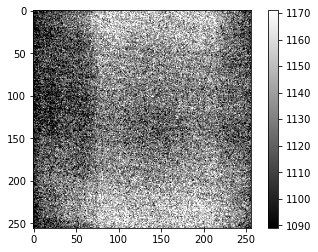

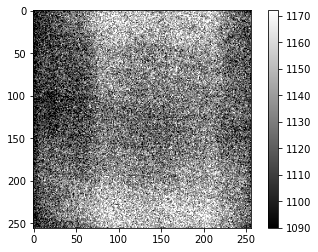

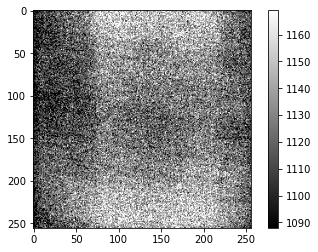

1129.993911743164 1130.8819122314453 1128.0595245361328


In [10]:
# First, create an empty numpy array of size 61x256x256 
# to hold all the data. Initially this can contain all 
# zeros; we'll replace those values shortly.

datastack = np.zeros((61,256,256))
print(type(datastack),datastack.shape)

# Then loop through all the filenames and set each "slice" 
# of the datastack to the individual image data.

for i,filename in enumerate(filenames):
    datastack[i] = fits.getdata(filename)

# datastack now contains all the 10-second dark data.
# Let's verify by displaying a few frames:

display(datastack[0])
display(datastack[1])
display(datastack[2])

# Each is slightly different, but they look generally 
# similar since they contain the same sources of noise. 
# We combine so many frames to "average" over the 
# random differences in individual images to get a more 
# representative calibration.

print(np.mean(datastack[0]),np.mean(datastack[1]),np.mean(datastack[2]))

In [11]:
# numpy functions like mean() and median() calculate 
# these values for the entire array by default, but 
# can operate on a projection through the array if 
# the optional "axis" parameter is specified.

? np.median

# Recall which axis corresponds to the "stacking" of
# the images.
print(datastack.shape)

(61, 256, 256)
Signature:  np.median(a, axis=None, out=None, overwrite_input=False, keepdims=False)
Docstring:
Compute the median along the specified axis.

Returns the median of the array elements.

Parameters
----------
a : array_like
    Input array or object that can be converted to an array.
axis : {int, sequence of int, None}, optional
    Axis or axes along which the medians are computed. The default
    is to compute the median along a flattened version of the array.
    A sequence of axes is supported since version 1.9.0.
out : ndarray, optional
    Alternative output array in which to place the result. It must
    have the same shape and buffer length as the expected output,
    but the type (of the output) will be cast if necessary.
overwrite_input : bool, optional
   If True, then allow use of memory of input array `a` for
   calculations. The input array will be modified by the call to
   `median`. This will save memory when you do not need to preserve
   the contents of t

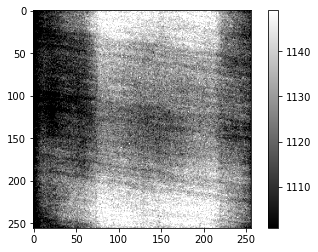

Mean: 1125.3980255126953


In [12]:
# Let's finally compute the master 10-second dark 
# calibration.

masterdark_10s = np.median(datastack,axis=0)
display(masterdark_10s)
print('Mean:',np.mean(masterdark_10s))


<mark>Q3: Why do we median-combine the frames rather than use the mean of the pixel values?</mark>

In [13]:
# As one last step for this image: let's write it out to 
# a FITS file so we can use it again later.

# The FITS file we write should contain both data and a 
# header. We can use the header we already read in from the 
# first dark, but we should modify the contents to indicate
# that this is the *master* dark, along with some info about
# how this master dark was created. Recall the astropy tutorial:
# http://www.astropy.org/astropy-tutorials/FITS-header.html
# Insert your name in the appropriate place.

newheader = header.copy()
newheader['COMMENT'] = "master 10-second dark"
newheader['COMMENT'] = str(len(filenames))+" frames median combined"
newheader['COMMENT'] = "processed by Abe Mankavil"

newheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXPTIME =                   10 / exposure time                                  
DATE-OBS= '2016-10-31T22:04:00' / date of the observation                       
OBJECT  = 'Dark    '           / name of observed object                        
RA_OBJ  = '' / R.A. of the observation                                          
DEC_OBJ = '' / declination of the observed object                               
OBSERVER= 'ZPV     '           / observer who acquired the data                 
TELESCOP= 'McDonald 2.1m'      / name of telescope                              
INSTRUME= 'ProEM   '        

In [14]:
# Finally, write it out to a FITS file:

fits.writeto("MasterDark_10s.fits",masterdark_10s,newheader,overwrite=True)

### Making the other Master Dark Frame

Phew... well we did the first one for you, but we also need to make a 3-second master dark frame.  This one is up to you, but it's pretty much the same as above.  Add new cells below as needed to produce this file (use the plus-sign button in the toolbar.

Here are some questions to answer along the way:

<mark>Q4: Comparing this 3-second master dark with the 10-second dark, approximate the typical counts-per-second dark current of this camera.</mark>

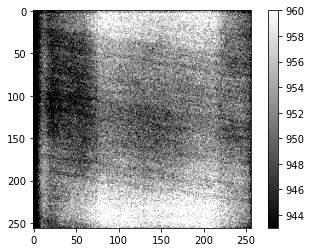

1038.653416993188


In [15]:
filenames2 = glob('dark/dark_3s-*.fits')
datastack2 = np.zeros((61,256,256))
for i,filename in enumerate(filenames2):
    datastack2[i] = fits.getdata(filename)
masterdark_3s = np.median(datastack2,axis=0)
display(masterdark_3s)
header = fits.getheader(filenames2[0])
newheader = header.copy()
newheader['COMMENT'] = "master 3-second dark"
newheader['COMMENT'] = str(len(filenames))+" frames median combined"
newheader['COMMENT'] = "processed by Abe Mankavil"
fits.writeto("MasterDark_3s.fits",masterdark_3s,newheader,overwrite=True)

print((np.mean(datastack)+np.mean(datastack2))/2)





### Making the Master Flat Frame

The process for making a master flat frame is similar to making the master dark frame, but there are a few important differences:
 1. The individual flat frames must be dark-subtracted (using the master dark with the same exposure time as the flats) before they are combined.
 * Because the lamp brightness can change while taking dome flats, we must normalize (divide) each dark-subtracted frame by its "mode" (remember the mode function we already defined for you).
 * (We still median-combine the dark-subtracted, normalized flat frames.)
 * Finally, we want to normalize the *master* flat by *its* mode so that the final pixel values represent fractional "efficiency" relative to the most typical pixel.

The first two steps need to be applied to each frame's data before it is put into a numpy array datastack (i.e., in the for loop).

That last step can be done after median combining the full set of frames, but before writing the master flat to a new FITS file.

<mark>Q5: What exposure time was used to take the individual flat frames?</mark>

<mark>Q6: Speculate why we might choose to normalize the individual flats by their mode rather than the median or the mean. Why might this matter more if we were taking twilight sky flats instead of dome flats?</mark>

<mark>Q7: Describe the structure in the master flat image.  What do you think might cause the dark areas to be shaped like little donuts?</mark>


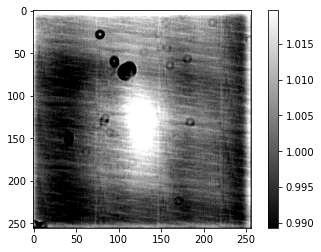

In [16]:
filenames3 = glob('flat/*.fits')
datastack3 = np.zeros((61,256,256))
for i,filename in enumerate(filenames3):
    x = fits.getdata(filename)-masterdark_3s
    x /= mode(x)
    datastack3[i] = x
masterflat = np.median(datastack3,axis=0)
masterflat /= mode(masterflat)
display(masterflat)
header = fits.getheader(filenames3[0])
newheader = header.copy()
newheader['COMMENT'] = "master flat"
newheader['COMMENT'] = str(len(filenames3))+" frames median combined"
newheader['COMMENT'] = "processed by Abe Mankavil"
fits.writeto("MasterFlat.fits",masterflat,newheader,overwrite=True)

    




### Reducing the Science Frames

Now that we have our final calibration frames, we can "reduce" our science frames (the files in the "ktwo220274129/" directory) so that they are ready for analysis in the next lab.

This is different from the last steps, since our goal is not to make a "master" frame (so we won't to stack the data).

Our aim this time is to read in each science frame, apply the appropriate dark subtraction and flat field correction, then write the reduced data out to a new frame. This should all happen within a for-loop. **Note that there are many more than 61 science frames. But we don't need to save them -- we can just read in each one, correct it, and write it back out to disk.**

Remember that the master dark (of equal exposure time to the science frames) is subtracted, and the master flat is divided.

<mark>Q8: Why are the darks subtracted, but the flats divided?</mark>

The frames that you write out should have slightly different filenames than the original frames (i.e., don't overwrite the originals!) that indicate that they are reduced. We suggest adding a "c" for "calibrated" to filename before the ".fits" extension (e.g., "ktwo220274129-0001.fits" -> "ktwo220274129-0001c.fits").

Also, be sure to add a comment with your name to the FITS headers so later users know who to ask if they have any questions about the specifics of the reduction process.

In [17]:
filenames4 = glob('ktwo220274129/*.fits')
for filename in filenames4:
    x = (fits.getdata(filename)-masterdark_10s)/(masterflat)
    newheader = header.copy()
    newheader['COMMENT'] = "Calibrated Science Frame"
    newheader['COMMENT'] = "processed by Abe Mankavil"
    fits.writeto(filename[:-5]+'c.fits',x,newheader,overwrite=True)





KeyboardInterrupt: 

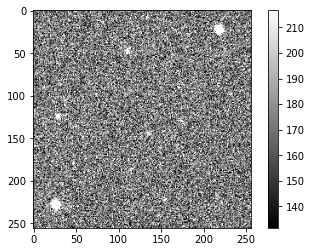

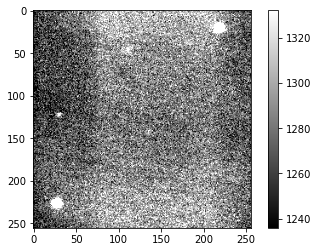

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                   16 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  256                                                  NAXIS2  =                  256                                                  EXPTIME =                   10 / exposure time                                  DATE-OBS= '2016-11-01T06:32:18' / date of the observation                       OBJECT  = 'ktwo220274129'      / name of observed object                        RA_OBJ  = '01:05:28.745'       / R.A. of the observation                        DEC_OBJ = '+02:05:01.14'       / declination of the observed object             OBSERVER= 'ZPV     '           / observer who acquired the data                 TELESCOP= 'McDonald 2.1m'      / name of telescope                              INSTRUME= 'ProEM   '           / name of

In [18]:
filenames4 = glob('ktwo220274129/*330c.fits')
display(fits.getdata(filenames4[0]))
filenames4 = glob('ktwo220274129/*330.fits')
display(fits.getdata(filenames4[0]))
print(fits.getheader(filenames4[0]))

<mark>Q9: Display both a calibrated and uncalibrated science frame and comment on the differences. What remaining sources of noise appear to be present in the reduced image?
**[Note: if you see two stars in the uncalibrated images but no stars in your corrected images, then you have done something wrong.]**</mark>

#### Great Work!!

Please upload the following to the Lab 3 Quiz on Canvas:

<mark>Q10: Upload your master 3-second dark FITS file.</mark>

<mark>Q11: Upload your master flat FITS file.</mark>

<mark>Q12: Upload *one* FITS file of a fully calibrated science frame.</mark>

<mark>Q13: Upload a PDF copy of this Notebook.</mark>